<a href="https://colab.research.google.com/github/lszam/fabrizio-mars/blob/main/fab_mars_mag_saida_qgis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Editor: Luizemara Szameitat     
Ver.1 17-04-2025*

In [37]:
!pip install rasterio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.8 MB/s eta 0:00:00


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata

Download dos dados magnéticos. **Altitude de 200 km nominal.**

In [ ]:
!wget "https://core2.gsfc.nasa.gov/research/purucker/br_spoabgt3_mars_rdipole_200km_1500cf_clip.xyz"

In [11]:
# Carregar e verificar o arquivo mag
file_path = 'br_spoabgt3_mars_rdipole_200km_1500cf_clip.xyz'

with open(file_path, 'r') as file:
    lines = file.readlines()

lines[:10]

['   -180.00    -88.00     26.09\n',
 '   -180.00    -87.00     45.55\n',
 '   -180.00    -86.00     53.78\n',
 '   -180.00    -85.00     57.34\n',
 '   -180.00    -84.00     76.63\n',
 '   -180.00    -83.00     96.04\n',
 '   -180.00    -82.00     90.78\n',
 '   -180.00    -81.00     49.83\n',
 '   -180.00    -80.00    -22.64\n',
 '   -180.00    -79.00   -111.42\n']

In [14]:
import pandas as pd

# Carregar os dados como um DataFrame para melhor controle
data_df = pd.read_csv(file_path, sep='\s+', header=None) #delim_whitespace=True vai ser descontinuado

# Exibir as primeiras linhas do DataFrame para verificar a estrutura
data_df.head()

,0,1,2
0,-180.0,-88.0,26.09
1,-180.0,-87.0,45.55
2,-180.0,-86.0,53.78
3,-180.0,-85.0,57.34
4,-180.0,-84.0,76.63


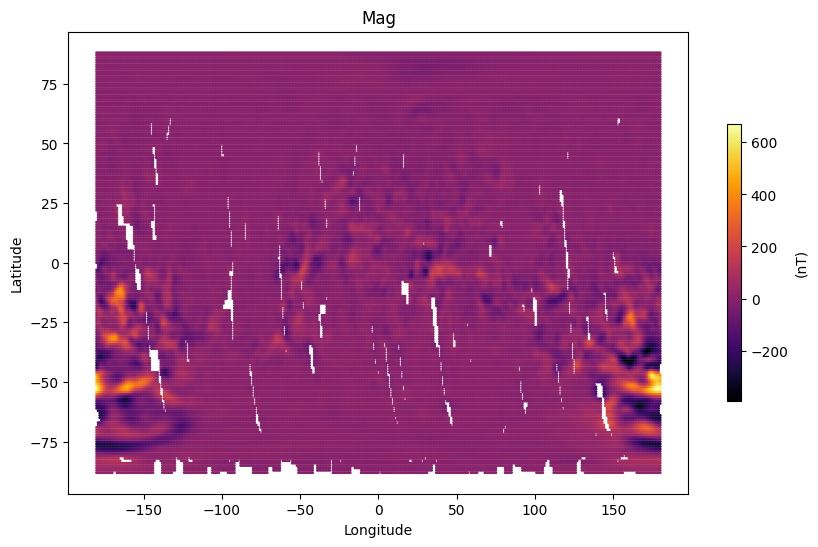

In [51]:
# Extrair dados das colunas e plotar como pontos para ver a distribuição
latitudes = data_df[1].values
longitudes = data_df[0].values
mag = data_df[2].values

plt.figure(figsize=(10, 6))
plt.scatter(longitudes, latitudes, c=mag, cmap='inferno', s=1)
plt.colorbar(label='(nT)', shrink=0.6)
plt.title('Mag')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


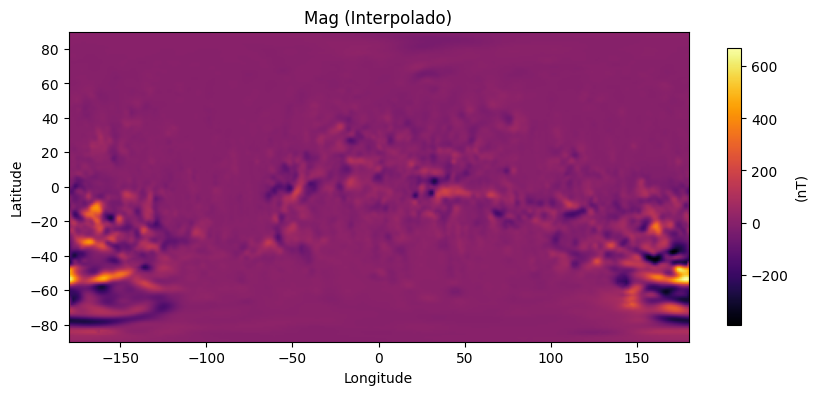

('mars_mag_geotiff_interpolado.tif', 'mars_mag_data.csv')

In [48]:
# Definir a resolução e o número de células da grade
lat_range = (latitudes.min(), latitudes.max())
lon_range = (longitudes.min(), longitudes.max())
n_rows = len(np.unique(latitudes))
n_cols = len(np.unique(longitudes))

# Calcular a resolução dos pixels
resolution_lat = (latitudes.max() - latitudes.min()) / len(np.unique(latitudes))
resolution_lon = (longitudes.max() - longitudes.min()) / len(np.unique(longitudes))

# Criar uma grade regular
# Trocar latitudes e longitudes nas variáveis meshgrid para corrigir o giro
lon_grid_regular, lat_grid_regular = np.meshgrid(np.linspace(longitudes.min(), longitudes.max(), n_cols), np.linspace(latitudes.min(), latitudes.max(), n_rows))


# Interpolar os valores do mag
mag_grid_regular = griddata((latitudes, longitudes), mag, (lat_grid_regular, lon_grid_regular), method='linear')

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(mag_grid_regular, cmap='inferno', extent=extent, origin='lower')
plt.colorbar(label='(nT)', shrink=0.6)
plt.title('Mag (Interpolado)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Transformação geográfica
transform = from_origin(lon_range[0], lat_range[1], resolution_lon, resolution_lat)

# Salvar GeoTIFF
geotiff_path = 'mars_mag_geotiff_interpolado.tif'
with rasterio.open(geotiff_path, 'w', driver='GTiff', height=n_rows, width=n_cols, count=1, dtype='float64', crs='EPSG:4326', transform=transform) as dst:
    dst.write(mag_grid_regular, 1)

# Salvar CSV
csv_path = 'mars_mag_data.csv'
data_df.to_csv(csv_path, index=False, header=False)

geotiff_path, csv_path




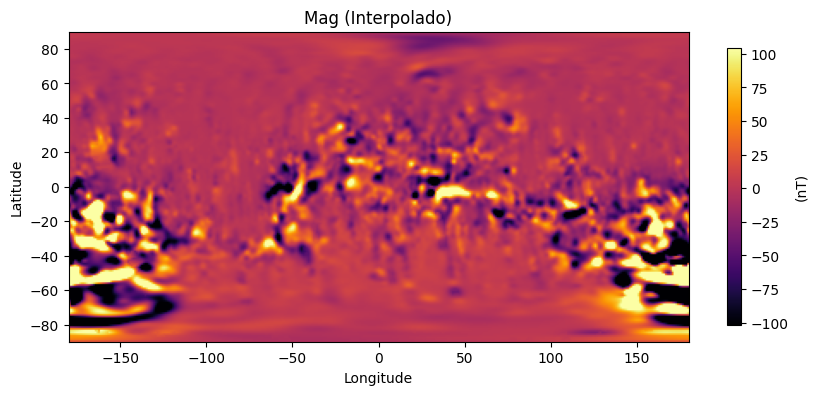

In [50]:
# Com normalização de contraste
extent = [-180, 180, -90, 90]
vmin, vmax = np.nanpercentile(mag, [2, 98])

plt.figure(figsize=(10, 6))
plt.imshow(mag_grid_regular, cmap='inferno', extent=extent, origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar(label='(nT)', shrink=0.6)
plt.title('Mag (Interpolado)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()